In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pyccl as ccl
import matplotlib.gridspec as gridspec
from scipy.optimize import curve_fit
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from scipy.stats import norm

plt.rcParams['figure.dpi'] = 85
plt.rcParams['figure.figsize'] = [10, 8]
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['lines.linewidth'] = 5
plt.rcParams['legend.fontsize'] = 16
plt.rcParams['legend.title_fontsize'] = 16
plt.rcParams['axes.linewidth'] = 2.5
plt.rcParams['xtick.major.size'] = 7
plt.rcParams['xtick.minor.size'] = 4
plt.rcParams['ytick.major.size'] = 4.32
plt.rcParams['ytick.minor.size'] = 2.46
plt.rcParams['xtick.major.width'] = 1.6
plt.rcParams['xtick.minor.width'] = 1.2
plt.rcParams['ytick.major.width'] = 1.6
plt.rcParams['ytick.minor.width'] = 1.2

# Figure 8: Set the priors!
### Define some global variables

In [2]:
home = '/oak/stanford/orgs/kipac/users/mahlet/bias/'

In [3]:
z_array = [0, 0.5, 1, 1.5]

cmap_red = plt.get_cmap('Reds')(np.linspace(0.333, 0.999, 4))
cmap_blue = plt.get_cmap('Blues')(np.linspace(0.333, 0.999, 4))
cmap_total = plt.get_cmap('Purples')(np.linspace(0.333, 0.999, 4))
color_red = cmap_red[1] 
color_blue = cmap_blue[1]
color_total = cmap_total[1] 

In [4]:
Lbox = 205

In [5]:
k1_idx = np.load(home + 'data/k1_idx.npy')
colors_patch = ['red', 'blue', 'purple']
labels = ['Quenched', 'Star-Forming', '$M_*$-Selected']
hodtypes = ['TNG', 'UM', r'$-\frac{2}{7}(b_1-1)$', 'Barreira+ (2021)']
colors_cmap_patch = [color_red, color_blue, color_total] 
cmap_patch = [cmap_red, cmap_blue, cmap_total]

### Define some functions

In [6]:
def error(hodtype, z, color, density, AB = ''):

    invmats = np.load(home + 'data/'+AB+'mpiinvmat_%shod_z%s_Ndown1_nbias5_%s_%s.npy'%(hodtype, z, color, density))
    nbar = np.load(home + 'data/'+AB+'mpinbar_%shod_z%s_Ndown1_nbias5_%s_%s.npy'%(hodtype, z,color, density))
    covvals = invmats.real[k1_idx]/nbar/Lbox**3  # divided by 2pi/dk is the same as times dx

    return np.sqrt(np.diag(covvals))

In [7]:
def f(b1, *params):
    return np.polynomial.polynomial.polyval(b1, params)

### Use curvefit to fit the data by galaxy type

In [8]:
data, errors, c, pcov = dict(), dict(), dict(), dict()
c_unweighted, pcov_unweighted = dict(), dict()
covvals_array = dict()
files = ['x_scatter_b1', 'y_scatter_b2', 'y_scatter_bs2', 'y_scatter_bnabla2', 'y_scatter_b3']
order = [1, 2, 2, 1, 3]
for color in ['red', 'blue', 'total']:
    
    data[color], errors[color], c[color], pcov[color] = dict(), dict(), dict(), dict()
    c_unweighted[color], pcov_unweighted[color] = dict(), dict()
    covvals_array[color] = np.load(home+'data/priors/covvals_'+color+'.npy')
    
    for j in range(len(files)):
    
        data[color][j] = np.load(home+'data/priors/'+files[j]+'_'+color+'.npy')
        errors[color][j] = [np.sqrt(np.diag(i))[j] for i in covvals_array[color]]
    
        # unweighted
        if j>=1:
            
            c_unweighted[color][j], pcov_unweighted[color][j] = curve_fit(f, data[color][0], data[color][j], p0=np.ones(order[j]+1))
            c[color][j], pcov[color][j] = curve_fit(f, data[color][0], data[color][j], p0=np.ones(order[j]+1), sigma = errors[color][j])

<>:39: SyntaxWarning: invalid escape sequence '\s'
<>:39: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_22259/3961004505.py:39: SyntaxWarning: invalid escape sequence '\s'
  second_legend = grid0.legend(custom_lines, ['mean', '1$\sigma$'], loc = 'lower right')


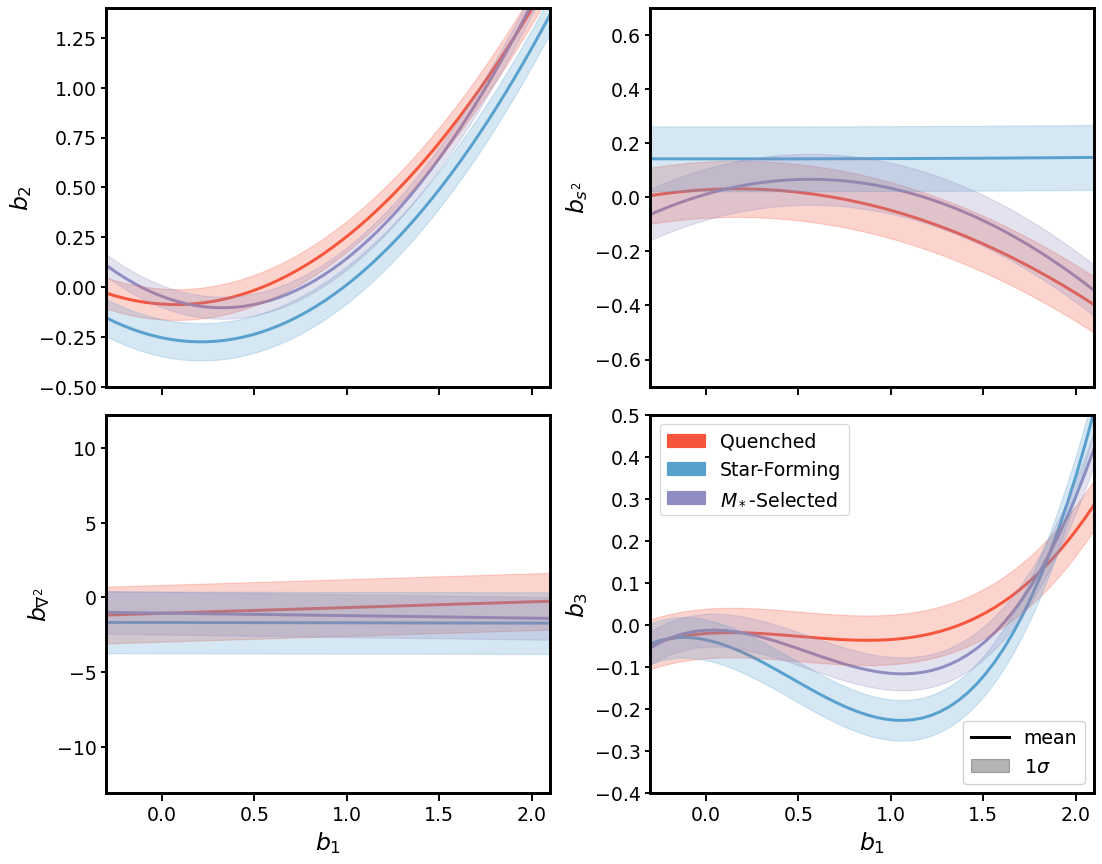

In [9]:
ylabel = ['$b_2$', '$b_{s^2}$', r'$b_{\nabla^2}$', '$b_3$']
xlim = -0.3, 2.1
b1_L_fit = np.linspace(xlim[0], xlim[1])

plt.figure(figsize = (15,12))
grid = gridspec.GridSpec(2, 2)
grid.update(wspace = 0.225, hspace = 0.075)

# plot by galaxy type
for color, plot_color, k in zip(['red', 'blue', 'total'], colors_cmap_patch, range(len(colors_cmap_patch))):        

    fit = ['${:.2f}b_1^2{:+.2f}b_1{:+.2f}$'.format(c[color][1][0], c[color][1][1], c[color][1][2]), 
       '${:.2f}b_1^2{:+.3f}b_1{:+.3f}$'.format(c[color][2][0], c[color][2][1], c[color][2][2]), 
       '${:.2f}b_1{:+.2f}$'.format(c[color][3][0], c[color][3][1]), 
       '${:.2f}b_1^3{:+.2f}b_1^2{:+.2f}b_1{:+.2f}$'.format(c[color][3][0], c[color][3][1], c[color][4][2], c[color][4][3])]
    
    for i, ylim in zip(range(len(ylabel)), [(-0.5, 1.4), (-0.7, 0.7), (-13.1, 12.2), (-0.4, 0.5)]): 

        grid0 = plt.subplot(grid[i])
        polyfit = np.polynomial.polynomial.polyval(b1_L_fit, c[color][i+1])
        sigma = np.std(data[color][i+1]-np.polynomial.polynomial.polyval(data[color][0], c[color][i+1]))
        grid0.plot(b1_L_fit, polyfit, color = plot_color, linewidth = 2.5, linestyle = '-', zorder = 0)
        grid0.fill_between(b1_L_fit, polyfit-sigma, polyfit+sigma, color = plot_color, alpha = 0.25) # 'silver', alpha = 0.5           
        grid0.set_ylabel(ylabel[i])
        grid0.set_xlim(np.array(xlim))
        grid0.set_ylim(np.array(ylim))

        if i<2:
            grid0.set_xticklabels([])
        else:
            grid0.set_xlabel('$b_1$')

patch = [mpatches.Patch(color=colors_cmap_patch[i], label=labels[i]) for i in range(len(labels))]
first_legend = grid0.legend(handles=patch, loc = 'upper left')
grid0.add_artist(first_legend)
        
custom_lines = [Line2D([0], [0], color = 'black', markersize = 10, linewidth = 2.5, linestyle = '-'), 
                mpatches.Patch(color='black', alpha = 0.25)]
second_legend = grid0.legend(custom_lines, ['mean', '1$\sigma$'], loc = 'lower right')
grid0.add_artist(second_legend)

plt.savefig(home + 'figures/Figure8.pdf', dpi = 300, bbox_inches='tight')
plt.show()

# Figure 9: Set priors on $b_1$
### Define a function

In [10]:
def err_prop(a, b, sigma_a, sigma_b):
    return np.sqrt(((1+a)/(1+b))**2*((sigma_a/(1+a))**2+(sigma_b/(1+b))**2))

### Use curvefit to fit the mean

In [11]:
covvals_array = dict()
redshift = dict()
b1_dict, b1_err_dict, yerr_dict = dict(), dict(), dict()
for color in ['red', 'blue', 'total']:
    
    covvals_array[color] = np.load(home+'data/priors/covvals_'+color+'.npy')    
    data[color][0] = np.load(home+'data/priors/x_scatter_b1_'+color+'.npy')
    errors[color][0] = [np.sqrt(np.diag(i))[0] for i in covvals_array[color]]
    redshift[color] = np.load(home+'data/priors/redshift_'+color+'.npy')
    b1_dict[color] = np.ravel([[data[color][0][i:i+2]]*4 for i in np.arange(6)*8])
    b1_err_dict[color] = np.ravel([[errors[color][0][i:i+2]]*4 for i in np.arange(6)*8])
    yerr_dict[color] = err_prop(data[color][0], b1_dict[color], errors[color][0], b1_err_dict[color])
    c[color][0], pcov[color][0] = curve_fit(f, redshift[color], (1+data[color][0])/(1+b1_dict[color]), p0=np.ones(3), sigma = yerr_dict[color])

### Use curvefit to fit $\sigma_{b_1}(z)$

In [12]:
redshift = dict()
b1_dict, b1_err_dict, yerr_dict = dict(), dict(), dict()
c_sigma, pcov_sigma = dict(), dict()
z_axis = [0,0.5,1,1.5]
for color in ['red', 'blue', 'total']:
    
    data[color][0] = np.load(home+'data/priors/x_scatter_b1_'+color+'.npy')
    errors[color][0] = [np.sqrt(np.diag(i))[0] for i in covvals_array[color]]
    redshift[color] = np.load(home+'data/priors/redshift_'+color+'.npy')
    
    b1_dict[color] = np.ravel([[data[color][0][i:i+2]]*4 for i in np.arange(6)*8])
    b1_err_dict[color] = np.ravel([[errors[color][0][i:i+2]]*4 for i in np.arange(6)*8])
    yerr_dict[color] = err_prop(data[color][0], b1_dict[color], errors[color][0], b1_err_dict[color])
    
    c[color][0], pcov[color][0] = curve_fit(f, redshift[color], (1+data[color][0])/(1+b1_dict[color]), p0=np.ones(3), sigma = yerr_dict[color])
    sigma = [np.std(np.array((1+data[color][0])/(1+b1_dict[color])-np.polynomial.polynomial.polyval(redshift[color], c[color][0]))[redshift[color]==i]) for i in [0,0.5,1,1.5]]
    c_sigma[color], pcov_sigma[color] = curve_fit(f, z_axis, sigma, p0=np.ones(2))

<>:62: SyntaxWarning: invalid escape sequence '\s'
<>:79: SyntaxWarning: invalid escape sequence '\s'
<>:62: SyntaxWarning: invalid escape sequence '\s'
<>:79: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_22259/2164153153.py:62: SyntaxWarning: invalid escape sequence '\s'
  grid0.text(0.025, 0.85, r'$B_1(z)=$'+fit+'\n$\sigma_{B_1}(z)=$'+fit_sigma, transform=grid0.transAxes, fontsize = 16)
/tmp/ipykernel_22259/2164153153.py:79: SyntaxWarning: invalid escape sequence '\s'
  second_legend = grid0.legend(custom_lines, ['mean', '1$\sigma$'], loc = 'lower right')


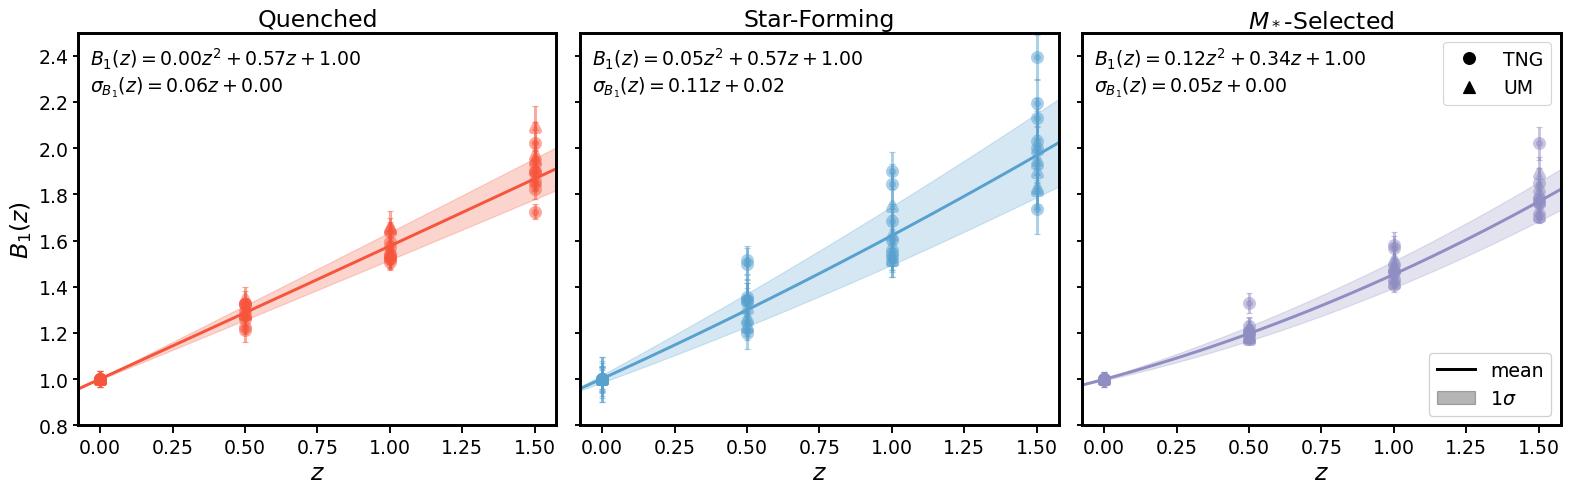

In [13]:
ylabel = ['$b_2$', '$b_{s^2}$', r'$b_{\nabla^2}$', '$b_3$']
xlim = -0.3, 2.1
zlim = redshift[color][0]-0.075, redshift[color][-1]+0.075
z_axis = np.linspace(zlim[0], zlim[1])
labels = ['Quenched', 'Star-Forming', '$M_*$-Selected']
colors_cmap_patch = [color_red, color_blue, color_total] 
hodtypes = ['TNG', 'UM']
k1_idx = np.load(home + 'data/k1_idx.npy')

fig = plt.figure(figsize = (22.5,6))
grid = gridspec.GridSpec(1, 3)
grid.update(wspace = 0.05, hspace = 0.05)

# plot by galaxy type
for color, plot_color, k in zip(['red', 'blue', 'total'], colors_cmap_patch, range(len(colors_cmap_patch))):        

    fit = '${:.2f}z^2{:+.2f}z{:+.2f}$'.format(c[color][0][2], c[color][0][1], c[color][0][0])
    fit_sigma = '${:.2f}z{:+.2f}$'.format(c_sigma[color][1], c_sigma[color][0])
    grid0 = plt.subplot(grid[k])

    polyfit = np.polynomial.polynomial.polyval(z_axis, c[color][0])
    polyfit_sigma = np.polynomial.polynomial.polyval(z_axis, c_sigma[color])
    grid0.plot(z_axis, polyfit, color = plot_color, linewidth = 2.5, linestyle = '-', zorder = 0)
    grid0.fill_between(z_axis, polyfit-polyfit_sigma, polyfit+polyfit_sigma, color = plot_color, alpha = 0.25) 
   
    for hodtype, marker in zip(hodtypes, ['o','^']):
        for density, alpha in zip(['low', 'medium', 'high'],[0.33, 0.67, 1]):
            for z, j in zip(z_array, range(len(z_array))):
                
                biasval = np.load(home + 'data/AB_mpibiasval_'+hodtype+'hod_z'+str(z)+'_Ndown1_nbias5_'+color+'_'+
                              density+'.npy')
                biasval_z0 = np.load(home + 'data/AB_mpibiasval_'+hodtype+'hod_z0_Ndown1_nbias5_'+color+'_'+
                              density+'.npy')

                # load error bars
                err = error(hodtype, z, color, density, AB = 'AB_')
                err_z0 = error(hodtype, 0, color, density, AB = 'AB_')
                yerr = err_prop(biasval[:,0][k1_idx], biasval_z0[:,0][k1_idx], err[0], err_z0[0])

                alpha = 0.5
                grid0.scatter(z, (1+biasval[:,0][k1_idx])/(1+biasval_z0[:,0][k1_idx]), color = plot_color, marker = marker, 
                          linewidth = 5, zorder = 3, alpha = alpha) 
                grid0.errorbar(z, (1+biasval[:,0][k1_idx])/(1+biasval_z0[:,0][k1_idx]), yerr = np.abs(yerr),
                           color = plot_color, fmt = 'none', elinewidth = 2.5, capsize = 2.5, alpha = alpha)
                    
                # plot original
                biasval = np.load(home + 'data/mpibiasval_'+hodtype+'hod_z'+str(z)+'_Ndown1_nbias5_'+color+'_'+
                              density+'.npy')
                biasval_z0 = np.load(home + 'data/mpibiasval_'+hodtype+'hod_z0_Ndown1_nbias5_'+color+'_'+
                              density+'.npy')

                # load error bars
                err = error(hodtype, z, color, density)
                err_z0 = error(hodtype, 0, color, density)
                yerr = err_prop(biasval[:,0][k1_idx], biasval_z0[:,0][k1_idx], err[0], err_z0[0])

                grid0.scatter(z, (1+biasval[:,0][k1_idx])/(1+biasval_z0[:,0][k1_idx]), color = plot_color, marker = marker, 
                          linewidth = 5, zorder = 3, alpha = alpha) 
                grid0.errorbar(z, (1+biasval[:,0][k1_idx])/(1+biasval_z0[:,0][k1_idx]), yerr = np.abs(yerr), #err[0] 
                           color = plot_color, fmt = 'none', elinewidth = 2.5, capsize = 2.5, alpha = alpha)

    grid0.text(0.025, 0.85, r'$B_1(z)=$'+fit+'\n$\sigma_{B_1}(z)=$'+fit_sigma, transform=grid0.transAxes, fontsize = 16)
    if k>0:
        grid0.set_yticklabels([])
    elif k==0:
        grid0.set_ylabel('$B_1(z)$')        
    grid0.set_xlim(zlim)
    grid0.set_ylim(0.8,2.5)
    grid0.set_xlabel('$z$')
    grid0.set_title(labels[k])
        
custom_lines = [Line2D([0], [0], color = 'black', markersize = 10, marker = 'o', linestyle = 'None'), 
                Line2D([0], [0], color = 'black', markersize = 10, marker = '^', linestyle = 'None')]
second_legend = grid0.legend(custom_lines, hodtypes, loc = 'upper right')
grid0.add_artist(second_legend)

custom_lines = [Line2D([0], [0], color = 'black', markersize = 10, linewidth = 2.5, linestyle = '-'), 
                mpatches.Patch(color='black', alpha = 0.25)]
second_legend = grid0.legend(custom_lines, ['mean', '1$\sigma$'], loc = 'lower right')
grid0.add_artist(second_legend)

plt.savefig(home + 'figures/Figure9.pdf', dpi = 300, bbox_inches='tight')
plt.show()

### Check that the residuals are Gaussian

<>:18: SyntaxWarning: invalid escape sequence '\s'
<>:20: SyntaxWarning: invalid escape sequence '\s'
<>:24: SyntaxWarning: invalid escape sequence '\h'
<>:18: SyntaxWarning: invalid escape sequence '\s'
<>:20: SyntaxWarning: invalid escape sequence '\s'
<>:24: SyntaxWarning: invalid escape sequence '\h'
/tmp/ipykernel_22259/567744312.py:18: SyntaxWarning: invalid escape sequence '\s'
  grid0.fill_between(z_axis, -np.array(polyfit_sigma), polyfit_sigma, color = color_thiswork, alpha = 0.25, label = '$1\sigma$')
/tmp/ipykernel_22259/567744312.py:20: SyntaxWarning: invalid escape sequence '\s'
  grid0.text(0.025, 0.85, '$B_1(z)=$'+fit+'\n$\sigma_{B_1}(z)=$'+fit_sigma, transform=grid0.transAxes, fontsize = 16)
/tmp/ipykernel_22259/567744312.py:24: SyntaxWarning: invalid escape sequence '\h'
  grid0.set_ylabel('$B_1-\hat{B_1}$')


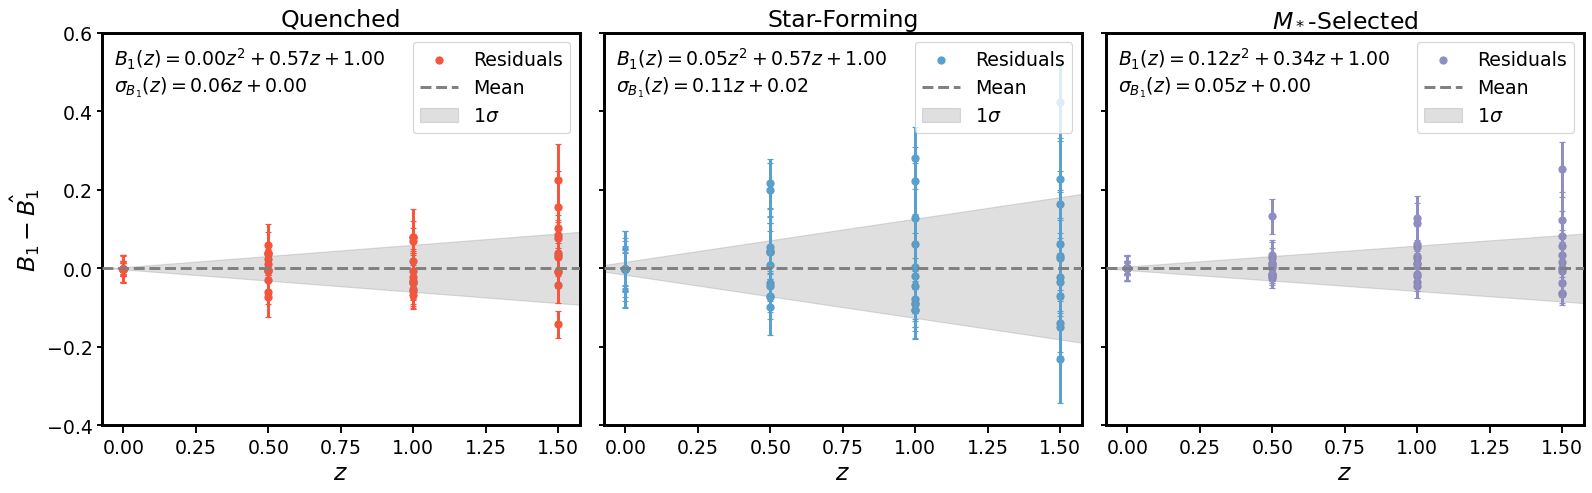

In [14]:
xlims = [-1.5,2.5],[-1000,1000],[-2,2.5]
z_axis = np.linspace(zlim[0], zlim[1])
color_thiswork = 'grey'

fig = plt.figure(figsize = (22.5,6))
grid = gridspec.GridSpec(1, 3)
grid.update(wspace = 0.05, hspace = 0.05)

for color, plot_color, title, k, xlim in zip(['red', 'blue', 'total'], colors_cmap_patch, labels, range(len(colors_cmap_patch)), xlims):
    fit = '${:.2f}z^2{:+.2f}z{:+.2f}$'.format(c[color][0][2], c[color][0][1], c[color][0][0])
    fit_sigma = '${:.2f}z{:+.2f}$'.format(c_sigma[color][1], c_sigma[color][0])
    grid0 = plt.subplot(grid[k])
    polyfit = np.polynomial.polynomial.polyval(redshift[color], c[color][0])
    sigma = [np.std(np.array((1+data[color][0])/(1+b1_dict[color])-np.polynomial.polynomial.polyval(redshift[color], c[color][0]))[redshift[color]==i]) for i in [0,0.5,1,1.5]]
    polyfit_sigma = np.polynomial.polynomial.polyval(z_axis, c_sigma[color])
    grid0.scatter(redshift[color], (1+data[color][0])/(1+b1_dict[color]) - polyfit, color = plot_color, label = 'Residuals')
    grid0.axhline(0, color = color_thiswork, linewidth = 2.5, linestyle = '--', zorder = 4, label = 'Mean')
    grid0.fill_between(z_axis, -np.array(polyfit_sigma), polyfit_sigma, color = color_thiswork, alpha = 0.25, label = '$1\sigma$') 
    grid0.errorbar(redshift[color], (1+data[color][0])/(1+b1_dict[color])-polyfit, yerr = yerr_dict[color], color = plot_color, fmt = 'none', elinewidth = 2.5, capsize = 2.5)
    grid0.text(0.025, 0.85, '$B_1(z)=$'+fit+'\n$\sigma_{B_1}(z)=$'+fit_sigma, transform=grid0.transAxes, fontsize = 16)
    if k>0:
        grid0.set_yticklabels([])
    else:
        grid0.set_ylabel('$B_1-\hat{B_1}$')
    grid0.set_xlabel('$z$')
    grid0.set_xlim(zlim)
    grid0.set_ylim(-0.4,0.6)
    grid0.set_title(title)
    grid0.legend(loc = 'upper right')
    
plt.show()

<>:16: SyntaxWarning: invalid escape sequence '\s'
<>:17: SyntaxWarning: invalid escape sequence '\h'
<>:16: SyntaxWarning: invalid escape sequence '\s'
<>:17: SyntaxWarning: invalid escape sequence '\h'
/tmp/ipykernel_22259/1525995662.py:16: SyntaxWarning: invalid escape sequence '\s'
  grid0.text(0.025, 0.85, '$B_1(z)=$'+fit+'\n$\sigma_{B_1}=$'+'{:.2f}'.format(sigma), transform=grid0.transAxes, fontsize = 16)
/tmp/ipykernel_22259/1525995662.py:17: SyntaxWarning: invalid escape sequence '\h'
  grid0.set_xlabel('$B_1-\hat{B_1}$')


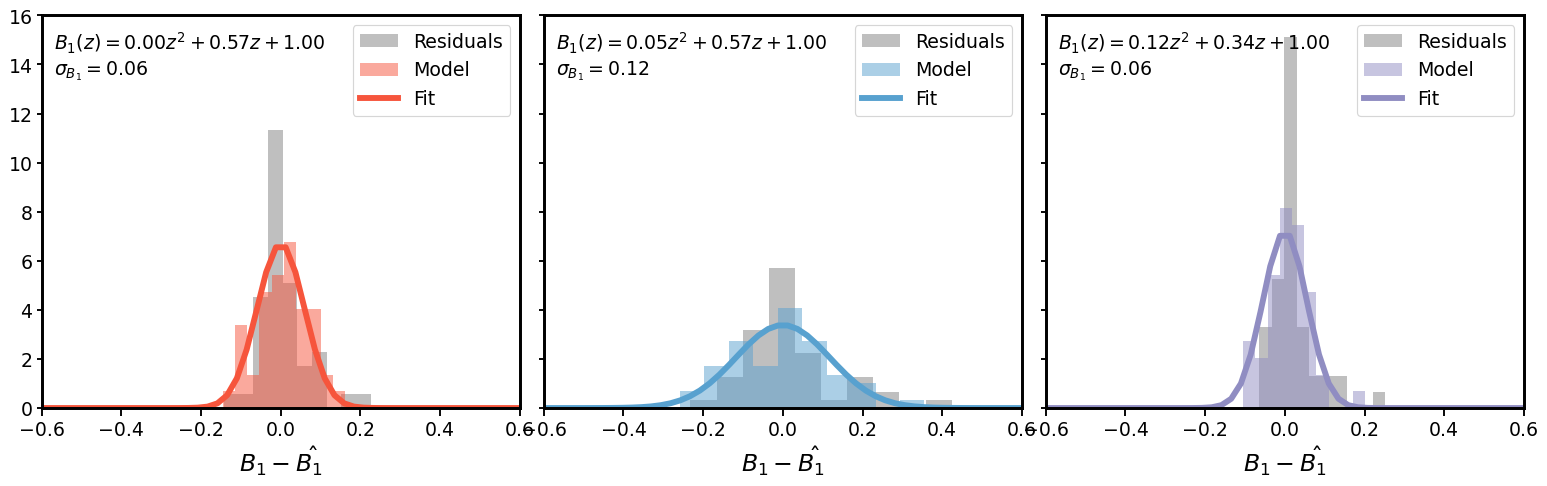

In [15]:
fig = plt.figure(figsize = (22.5,6))
grid = gridspec.GridSpec(1, 3)
grid.update(wspace = 0.05, hspace = 0.05)
    
xlim = -0.6,0.6
for color, plot_color, title, k in zip(['red', 'blue', 'total'], colors_cmap_patch, labels, range(len(colors_cmap_patch))):        

    grid0 = plt.subplot(grid[k])
    fit = '${:.2f}z^2{:+.2f}z{:+.2f}$'.format(c[color][0][2], c[color][0][1], c[color][0][0])
    polyfit = np.polynomial.polynomial.polyval(redshift[color], c[color][0])
    sigma = np.std((1+data[color][0])/(1+b1_dict[color])-polyfit)
    grid0.hist((1+data[color][0])/(1+b1_dict[color])-polyfit, density = True, color = 'grey', alpha = 0.5, label = 'Residuals')
    grid0.hist(norm.rvs(scale = sigma, size = len(polyfit)), density = True, alpha = 0.5, color = plot_color, label = 'Model')
    x = np.linspace(xlim[0],xlim[1])
    grid0.plot(x, norm.pdf(x, scale = sigma), color = plot_color, linewidth = 5, label = 'Fit')
    grid0.text(0.025, 0.85, '$B_1(z)=$'+fit+'\n$\sigma_{B_1}=$'+'{:.2f}'.format(sigma), transform=grid0.transAxes, fontsize = 16)
    grid0.set_xlabel('$B_1-\hat{B_1}$')
    grid0.set_xlim(xlim[0],xlim[1])
    grid0.set_ylim(0,16)
    grid0.legend()
    if k>0:
        grid0.set_yticklabels([])

plt.show()

### Check how much the fit to $\sigma(z)$ differs from the measured $\sigma(z)$

In [16]:
z_axis = [0,0.5,1,1.5]

for color in ['red', 'blue', 'total']:
    polyfit_sigma = np.polynomial.polynomial.polyval(z_axis, c_sigma[color])
    sigma = [np.std(np.array((1+data[color][0])/(1+b1_dict[color])-np.polynomial.polynomial.polyval(redshift[color], c[color][0]))[redshift[color]==i]) for i in [0,0.5,1,1.5]]
    print(polyfit_sigma-sigma)

[ 0.00277184 -0.00808769  0.00785984 -0.002544  ]
[ 0.01660372 -0.02479657 -0.00021803  0.00841087]
[ 0.00458259 -0.00948262  0.00521749 -0.00031745]


# Sanity check that a quadratic fit to $b_1$ makes sense
### Define some global variables

In [17]:
bins_offset = 0.1
bins = np.logspace(10, 15+bins_offset, 50)

In [18]:
h = 0.6774
delta_c = 1.686

In [19]:
cosmo_default = ccl.Cosmology(Omega_b=0.0486, Omega_c=0.2589, h=h, n_s=0.9667, sigma8=0.8159)

### Define some functions

In [20]:
def scale_factor(z):
    return 1/(1+z)

def recenter(bins):
    return 0.5*(bins[1:]+bins[:-1])

In [21]:
def nu(M, delta_c = delta_c, a = 1, cosmo = cosmo_default):
    
    sigma = cosmo.sigmaM(M/cosmo['h'], a = a)
   
    return delta_c/sigma

In [22]:
def b1(nu_array, delta_c):
    return (np.array(nu_array)**2-1)/delta_c

In [23]:
def b2(nu_array, delta_c):
    return nu_array**2*(nu_array**2-3)/delta_c

### Visualize $b_1(z|M)=\frac{\nu^2(z|M)-1}{\delta_c}$ to see that $b_1\propto(1+z)^2$, especially at high $M$!

<>:13: SyntaxWarning: invalid escape sequence '\o'
<>:14: SyntaxWarning: invalid escape sequence '\o'
<>:15: SyntaxWarning: invalid escape sequence '\s'
<>:13: SyntaxWarning: invalid escape sequence '\o'
<>:14: SyntaxWarning: invalid escape sequence '\o'
<>:15: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_22259/4161984249.py:13: SyntaxWarning: invalid escape sequence '\o'
  grid0.plot(z_plot,1/np.array(nu_array)*delta_c, label = 'log$_{{10}}($M/M$\odot)=${:.3f}'.format(np.log10(recenter(bins)[0])))
/tmp/ipykernel_22259/4161984249.py:14: SyntaxWarning: invalid escape sequence '\o'
  grid0.plot(z_plot,1/np.array(nu_array1)*delta_c, label = 'log$_{{10}}($M/M$\odot)=${:.3f}'.format(np.log10(recenter(bins)[-1])))
/tmp/ipykernel_22259/4161984249.py:15: SyntaxWarning: invalid escape sequence '\s'
  grid0.set_ylabel('$\sigma(z|M)$')


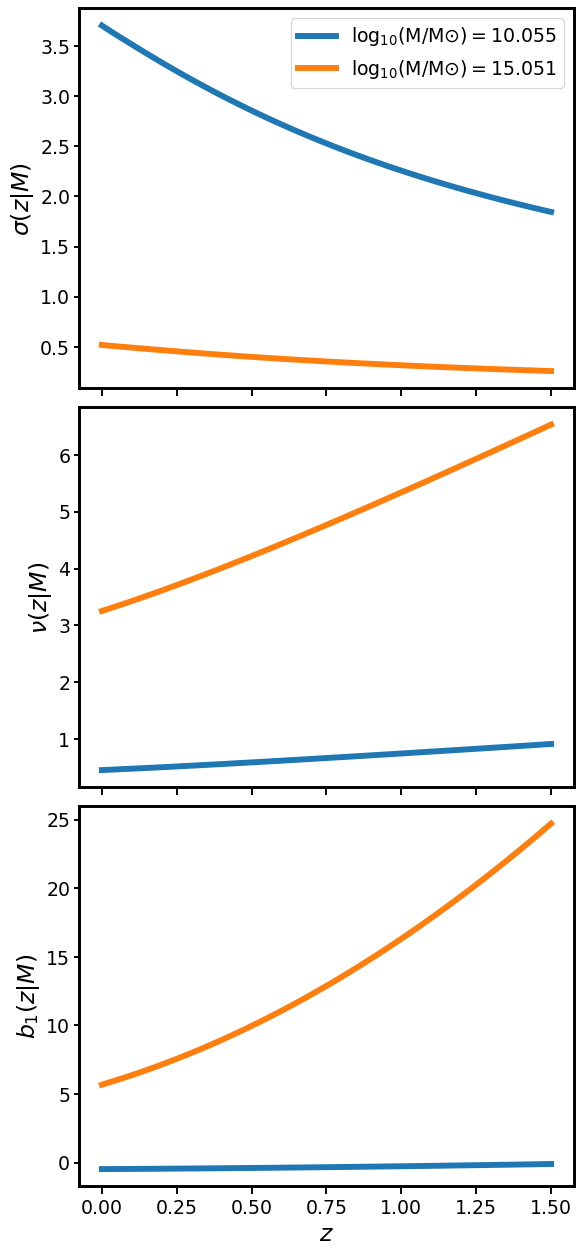

In [24]:
# start with nu=delta_c/sigma
z_plot = np.linspace(z_array[0], z_array[-1])
nu_array, nu_array1 = [],[]
for a in scale_factor(z_plot):
    nu_array.append(nu(recenter(bins)[0], a = a))
    nu_array1.append(nu(recenter(bins)[-1], a = a))

plt.figure(figsize = (7.5,18))
grid = gridspec.GridSpec(3, 1)
grid.update(wspace = 0.125, hspace = 0.05)

grid0 = plt.subplot(grid[0])
grid0.plot(z_plot,1/np.array(nu_array)*delta_c, label = 'log$_{{10}}($M/M$\odot)=${:.3f}'.format(np.log10(recenter(bins)[0])))
grid0.plot(z_plot,1/np.array(nu_array1)*delta_c, label = 'log$_{{10}}($M/M$\odot)=${:.3f}'.format(np.log10(recenter(bins)[-1])))
grid0.set_ylabel('$\sigma(z|M)$')
grid0.set_xticklabels([])
grid0.legend()

grid0 = plt.subplot(grid[1])
grid0.plot(z_plot,nu_array)
grid0.plot(z_plot,nu_array1)
grid0.set_ylabel(r'$\nu(z|M)$')
grid0.set_xticklabels([])

grid0 = plt.subplot(grid[2])
plt.plot(z_plot, b1(nu_array, delta_c))
plt.plot(z_plot, b1(nu_array1, delta_c))
grid0.set_xlabel('$z$')
grid0.set_ylabel(r'$b_1(z|M)$')
plt.show()

### Check that the bias parameters are independent of cosmology

In [25]:
cosmo_tng = [0.0486,  0.2589, h, 0.9667, 0.8159]
cosmo_plik = [0.022383/0.6732**2,  0.12011/0.6732**2, 0.6732, 0.96605, 0.8120]
cosmo_fake = [0.05,  0.3, 0.7, 0.95, 0.8]

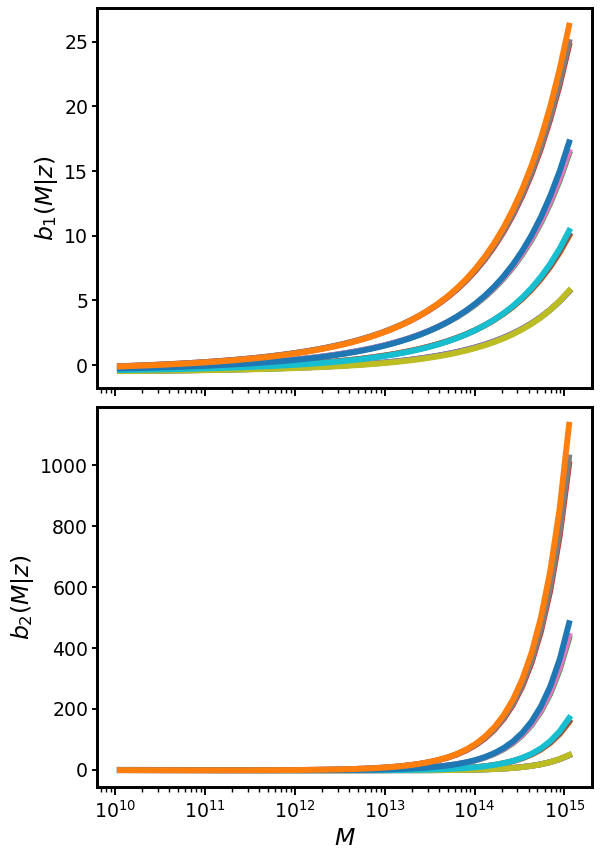

In [26]:
plt.figure(figsize = (7.5,18))
grid = gridspec.GridSpec(3, 1)
grid.update(wspace = 0.125, hspace = 0.05)

grid0 = plt.subplot(grid[0])
grid0.set_xscale('log')
grid0.set_ylabel(r'$b_1(M|z)$')
grid0.set_xticklabels([])

grid1 = plt.subplot(grid[1])
grid1.set_xscale('log')
grid1.set_ylabel(r'$b_2(M|z)$')
grid1.set_xlabel('$M$')

# calculate b1(M) for several different cosmologies and redshifts at a fixed array of mass
for cosmo_params in [cosmo_tng, cosmo_plik, cosmo_fake]:
    
    Omega_b, Omega_c, h, n_s, sigma8 = cosmo_params
    cosmo = ccl.Cosmology(Omega_b=Omega_b, Omega_c=Omega_c, h=h, n_s=n_s, sigma8=sigma8)

    for z in z_array:
        M = recenter(bins)
        nu_array = nu(M, delta_c = delta_c, a = scale_factor(z), cosmo = cosmo)
        grid0.plot(M, b1(nu_array, delta_c))

        # calculate b2(M) for those cosmologies
        grid1.plot(M, b2(nu_array, delta_c))

plt.show()

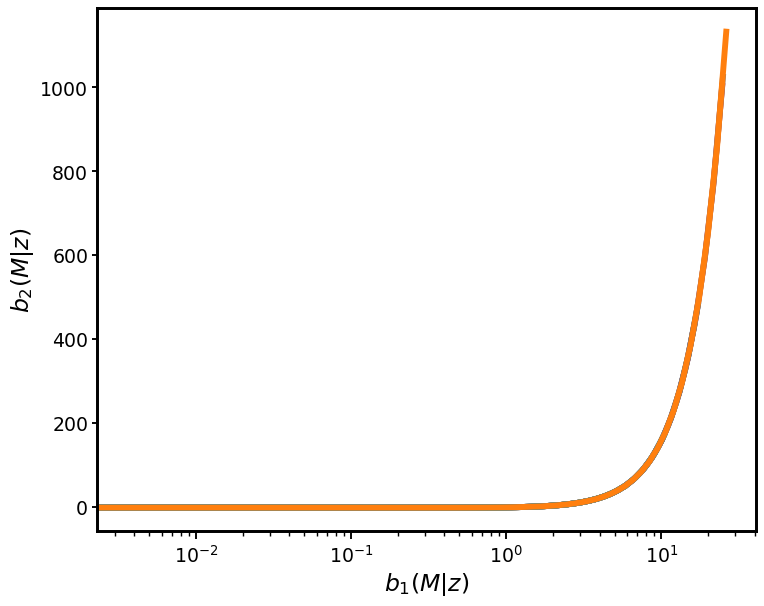

In [27]:
# plot the curve b_2 (b_1) instead of b_2 (M). 
# What happens to the original scatter that you had in b2(M)? 
# --> scatter vanishes, stays fixed even as cosmology and z change

# calculate b1(M) for several different cosmologies and redshifts at a fixed array of mass
for cosmo_params in [cosmo_tng, cosmo_plik, cosmo_fake]:
    
    Omega_b, Omega_c, h, n_s, sigma8 = cosmo_params
    cosmo = ccl.Cosmology(Omega_b=Omega_b, Omega_c=Omega_c, h=h, n_s=n_s, sigma8=sigma8)

    for z in z_array:
        M = recenter(bins)
        nu_array = nu(M, delta_c = delta_c, a = scale_factor(z), cosmo = cosmo)
        plt.plot(b1(nu_array, delta_c), b2(nu_array, delta_c))

plt.xscale('log')
plt.ylabel(r'$b_2(M|z)$')
plt.xlabel('$b_1(M|z)$')
plt.show()